In [277]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# MARATONA BEHIND THE CODE 2020

## DESAFIO 2: PARTE 1

### Introdução

Em projetos de ciência de dados visando a construção de modelos de *machine learning*, ou aprendizado estatístico, é muito incomum que os dados iniciais estejam já no formato ideal para a construção de modelos. São necessários vários passos intermediários de pré-processamento de dados, como por exemplo a codificação de variáveis categóricas, normalização de variáveis numéricas, tratamento de dados faltantes, etc. A biblioteca **scikit-learn** -- uma das mais populares bibliotecas de código-aberto para *machine learning* no mundo -- possui diversas funções já integradas para a realização das transformações de dados mais utilizadas. Entretanto, em um fluxo comum de um modelo de aprendizado de máquina, é necessária a aplicação dessas transformações pelo menos duas vezes: a primeira vez para "treinar" o modelo, e depois novamente quando novos dados forem enviados como entrada para serem classificados por este modelo. 

Para facilitar o trabalho com esse tipo de fluxo, o scikit-learn possui também uma ferramenta chamada **Pipeline**, que nada mais é do que uma lista ordenada de transformações que devem ser aplicadas nos dados. Para auxiliar no desenvolvimento e no gerenciamento de todo o ciclo-de-vida dessas aplicações, alem do uso de Pipelines, as equipes de cientistas de dados podem utilizar em conjunto o **Watson Machine Learning**, que possui dezenas de ferramentas para treinar, gerenciar, hospedar e avaliar modelos baseados em aprendizado de máquina. Além disso, o Watson Machine Learning é capaz de encapsular pipelines e modelos em uma API pronta para uso e integração com outras aplicações.

Durante o desafio 2, você participante irá aprender a construir uma **Pipeline** para um modelo de classificação e hospedá-lo como uma API com o auxílio do Watson Machine Learning. Uma vez hospedado, você poderá integrar o modelo criado com outras aplicações, como assistentes virtuais e muito mais. Neste notebook, será apresentado um exemplo funcional de criação de um modelo e de uma pipeline no scikit-learn (que você poderá utilizar como template para a sua solução!).

### Trabalhando com Pipelines do scikit-learn

In [276]:
# Primeiro, realizamos a instalação do scikit-learn versão 0.20.0 no Kernel deste notebook:
!pip install -r ../../requirements.txt

# Se você esta usando MacOS talvez precise instalar esta dependência
#!brew install libomp

You should consider upgrading via the 'pip install --upgrade pip' command.


In [266]:
import json
import requests
import pandas as pd
import numpy as np
import warnings
import xgboost as xgb

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.pipeline import Pipeline

from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')


In [267]:
import pandas as pd

df = pd.read_csv('/Users/alexandre/Projects/btc-2020/desafio-2-2020/cloud-pak-project-ptbr-2/assets/data_asset/dataset_desafio_2.csv')
# df.head()

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [229]:
from sklearn.base import BaseEstimator, TransformerMixin

# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primeiro realizamos a cópia do dataframe 'X' de entrada
        data = X.copy()
        # Retornamos um novo dataframe sem as colunas indesejadas
        return data.drop(labels=self.columns, axis='columns')

In [268]:
# Instanciando uma transformação DropColumns
rm_columns = DropColumns(
    columns=[
        "NOME",
        "NOTA_GO",
        "INGLES",
        "MATRICULA"
    ]  # Essa transformação recebe como parâmetro uma lista com os nomes das colunas indesejadas
)


In [269]:
# Aplicando a transformação ``DropColumns`` ao conjunto de dados base
rm_columns.fit(X=df)

# Reconstruindo um DataFrame Pandas com o resultado da transformação
df_data_2 = pd.DataFrame.from_records(
    data=rm_columns.transform(
        X=df
    ),
)

In [278]:
# Definição das colunas que serão features (nota-se que a coluna NOME não está presente)
features = [
    'REPROVACOES_DE', 
    'REPROVACOES_EM', 
    "REPROVACOES_MF", 
    "REPROVACOES_GO",
    "NOTA_DE", 
    "NOTA_EM", 
    "NOTA_MF", 
    "H_AULA_PRES", 
    "TAREFAS_ONLINE", 
    "FALTAS", 
]

# Definição da variável-alvo
target = ["PERFIL"]

# Preparação dos argumentos para os métodos da biblioteca ``scikit-learn``
X = df_data_2[features]
y = df_data_2[target]

In [258]:
# Separação dos dados em um conjunto de treino e um conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=337)

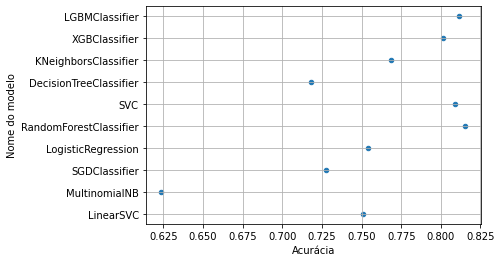

In [285]:
# Método para rodar os classificadores
def classify(classifier, X_train, y_train, X_test, y_test):
  classifier_name = classifier.__class__.__name__

  classifier.fit(X_train, y_train)
  y_predict = classifier.predict(X_test)
  
  return [
    classifier_name, 
    accuracy_score(y_test, y_predict),
  ]

classifiers = [
    LinearSVC(),
    MultinomialNB(),
    SGDClassifier(loss="hinge", penalty="l2",alpha=1e-3, random_state=42, max_iter=5, tol=None),
    LogisticRegression(random_state=0),
    RandomForestClassifier(n_estimators=20, max_depth=10, random_state=0),
    SVC(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(n_neighbors=10),
    XGBClassifier(),
    LGBMClassifier(),
]

entries = [ 
  classify(classifier, X_train, y_train, X_test, y_test) for classifier in classifiers
]

# Conferindo qual Classificador objeteve melhor acurácia
df_metrics = pd.DataFrame(entries, columns=["model_name", "accuracy_score"])
df_metrics.plot.scatter(y='model_name', x='accuracy_score', grid=True)
plt.xlabel("Acurácia")
plt.ylabel("Nome do modelo")
plt.show()

In [346]:
## from sklearn.metrics import accuracy_score, classification_report

# Criação da árvore de decisão com a biblioteca ``scikit-learn``:
dtc_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
# dtc_model = LGBMClassifier()
# Treino do modelo (é chamado o método *fit()* com os conjuntos de treino)
dtc_model.fit(X_train, y_train)

# Realização de teste cego no modelo criado
y_pred = dtc_model.predict(X_test)

# Acurácia alcançada
print("Acurácia: {}%".format(100*round(accuracy_score(y_test, y_pred), 2)))
print(classification_report(y_test, y_pred))

Acurácia: 82.0%
              precision    recall  f1-score   support

 DIFICULDADE       0.90      0.74      0.81      1402
      EXATAS       0.80      0.93      0.86      1629
   EXCELENTE       0.68      0.66      0.67       145
     HUMANAS       0.77      0.96      0.86       639
   MUITO_BOM       0.40      0.04      0.08       185

   micro avg       0.82      0.82      0.82      4000
   macro avg       0.71      0.67      0.65      4000
weighted avg       0.81      0.82      0.80      4000

